Using device: cuda:0


Using cache found in /mnt/ssd/users/hossein/models\pytorch_vision_v0.10.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving to: Viz


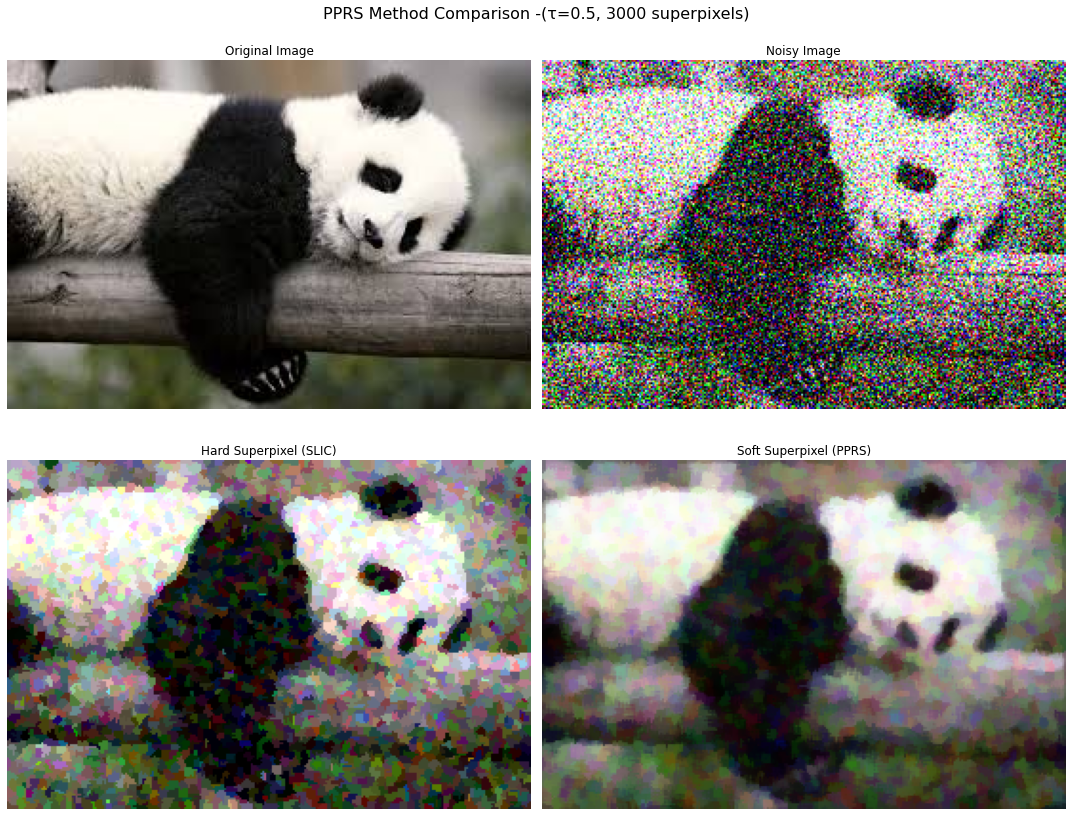

Visualization completed!


In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import get_dataset
from architectures import get_architecture
from superpixelf import SuperSmoothSoft as SuperSmooth
from superpixelf import convolve_batch, construct_kernel

# Set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Simple parameters - only tau and number of superpixels as inputs
ns = 3000  # Number of superpixels (input parameter)
tau = 0.5  # Superpixel smoothing temperature (input parameter)
sigma = 0.5

img_path = 'sample.jpeg'
x_np = plt.imread(img_path)
if x_np.dtype.kind in "ui":
    x_np = x_np.astype(np.float32) / 255.0
else:
    x_np = x_np.astype(np.float32)
x = torch.from_numpy(x_np).permute(2,0,1).unsqueeze(0).to(device)


# dummy calssifier
base_classifier = get_architecture('resnet18', 'cifar10', device=device)  
num_classes = 10

smoothed_classifier = SuperSmooth(
    base_classifier=base_classifier,
    num_classes=num_classes,
    sigma=sigma,
    k=5,
    ns=ns,
    tau=tau,
    device=device,
    alg='soft'
)

superpixel_images_soft, labels_soft, superpixel_images_hard, labels_hard, noisy_image = smoothed_classifier.sample_partioning(x, 0.4)


sigma_str = str(sigma).replace('.', 'p')
out_dir = os.path.join("Viz")
os.makedirs(out_dir, exist_ok=True)
print(f"Saving to: {out_dir}")

def tensor_to_numpy(tensor):
    return tensor.permute(1, 2, 0).detach().cpu().numpy()

orig_np = tensor_to_numpy(x[0])
noisy_np = tensor_to_numpy(noisy_image[0])
pprs_soft_np = tensor_to_numpy(superpixel_images_soft[0])
pprs_hard_np = tensor_to_numpy(superpixel_images_hard[0])

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'PPRS Method Comparison -(τ={tau}, {ns} superpixels)', fontsize=16)

axs[0, 0].imshow(orig_np)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(noisy_np)
axs[0, 1].set_title('Noisy Image')
axs[0, 1].axis('off')

axs[1, 0].imshow(pprs_hard_np)
axs[1, 0].set_title('Hard Superpixel (SLIC)')
axs[1, 0].axis('off')

axs[1, 1].imshow(pprs_soft_np) 
axs[1, 1].set_title('Soft Superpixel (PPRS)')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Visualization completed!")